### Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [89]:
users = pd.read_csv("users_articles.csv")
print(users.shape)
users.head(3)

(8000, 2)


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/Users/nadejdaberzina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 28.5 s, sys: 314 ms, total: 28.8 s
Wall time: 30 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 53s, sys: 1.06 s, total: 3min 54s
Wall time: 19min 22s


А теперь в 3 строчки обучим нашу модель

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [12]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 14s, sys: 1.13 s, total: 1min 15s
Wall time: 56.9 s


In [14]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [15]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.35784015),
 (9, 0.5074288),
 (13, 0.041662868),
 (20, 0.04044475),
 (24, 0.03145984)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: взрыв родственник ввс сигнал фаза ученик армия
topic_1: млн форум тыс сайт составить вирус разместить
topic_2: новый всё вопрос развитие научный банк nn
topic_3: nn место женщина земля мужчина высота воздух
topic_4: станция наука программа проект объект век запуск
topic_5: болезнь страдать девочка вуз медведев пища стол
topic_6: гражданин сша россия восток российский введение nn
topic_7: рубль газета сотрудник nn обнаружить лицо ru
topic_8: северный земля российский территория рак температура рынок
topic_9: исследование первый всё большой день очень уровень
topic_10: статья выяснить ресурс ст треть виза выдать
topic_11: санкция сша россия снижение правительство решение глава
topic_12: двигатель экипаж космос пилот озеро лётчик превысить
topic_13: поверхность тур экскурсия парка седьмой молдавия горький
topic_14: россия российский путин китай ставка исследование nn
topic_15: фонд университет исследование топливо лаборатория фотография пилотировать
topic_16: россия украина военн

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [17]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.056906,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.54742,0.000000,0.0,0.0,0.344882,0.000000
1,4896,0.257455,0.000000,0.0,0.0,0.0,0.0,0.000000,0.282386,0.0,...,0.0,0.180306,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
2,4897,0.000000,0.357893,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.040446,0.0,0.0,0.000000,0.031474
3,4898,0.000000,0.000000,0.0,0.0,0.0,0.0,0.238205,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000
4,4899,0.000000,0.132464,0.0,0.0,0.0,0.0,0.840459,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
doc_dict[293622]

array([0.        , 0.22033666, 0.09732271, 0.08143129, 0.        ,
       0.        , 0.        , 0.24241757, 0.03226387, 0.        ,
       0.06573426, 0.0155695 , 0.        , 0.        , 0.07838448,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03791972, 0.        , 0.        , 0.        , 0.11843108])

In [124]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [125]:
get_user_embedding(user_articles_list)

array([0.05392542, 0.        , 0.5232814 , 0.08885277, 0.        ,
       0.        , 0.04316615, 0.33474591, 0.12395588, 0.17499577,
       0.        , 0.48421991, 0.        , 0.        , 0.50989521,
       0.01300042, 0.3398681 , 0.        , 0.04735432, 0.15034977,
       0.        , 0.        , 0.        , 0.43282756, 0.08216587])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [68]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.030669,0.228433,0.373733,0.081431,0.115537,0.014065,0.309369,0.242418,0.032264,...,0.031687,0.139305,0.295798,0.098664,0.078663,0.037920,0.000000,0.039939,0.326165,0.266281
1,u108690,0.000000,0.046839,0.420348,0.084494,0.011503,0.090845,0.010528,0.333264,0.024140,...,0.000000,0.279460,0.024444,0.125562,0.079422,0.050391,0.014592,0.000000,0.201774,0.102271
2,u108339,0.000000,0.046329,0.213979,0.103285,0.055668,0.000000,0.117875,0.326336,0.034968,...,0.000000,0.221463,0.030866,0.144037,0.219212,0.054866,0.000000,0.000000,0.162330,0.100760


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [69]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [70]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.030669,0.228433,0.373733,0.081431,0.115537,0.014065,0.309369,0.242418,0.032264,...,0.139305,0.295798,0.098664,0.078663,0.037920,0.000000,0.039939,0.326165,0.266281,0
1,u108690,0.000000,0.046839,0.420348,0.084494,0.011503,0.090845,0.010528,0.333264,0.024140,...,0.279460,0.024444,0.125562,0.079422,0.050391,0.014592,0.000000,0.201774,0.102271,1
2,u108339,0.000000,0.046329,0.213979,0.103285,0.055668,0.000000,0.117875,0.326336,0.034968,...,0.221463,0.030866,0.144037,0.219212,0.054866,0.000000,0.000000,0.162330,0.100760,1


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [72]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [73]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([9.19025285e-02, 5.71742416e-04, 8.46190817e-01, 1.39902573e-01,
       4.30155758e-02, 1.09941363e-02, 1.84547981e-01, 2.78460886e-02,
       5.29940668e-04, 3.77149025e-01])

In [75]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [76]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.324107, F-Score=0.784, Precision=0.748, Recall=0.824


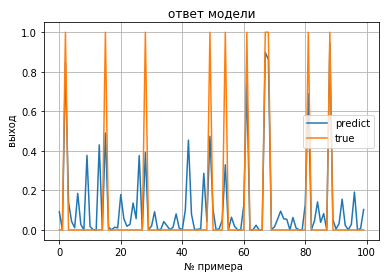

In [77]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

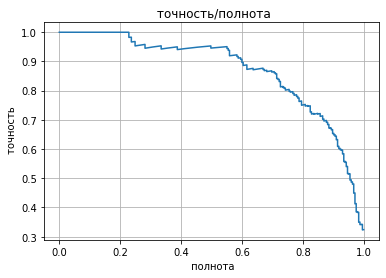

In [78]:
plt.plot(recall,precision )
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [80]:
import itertools

Confusion matrix, without normalization
[[1687   68]
 [  44  201]]


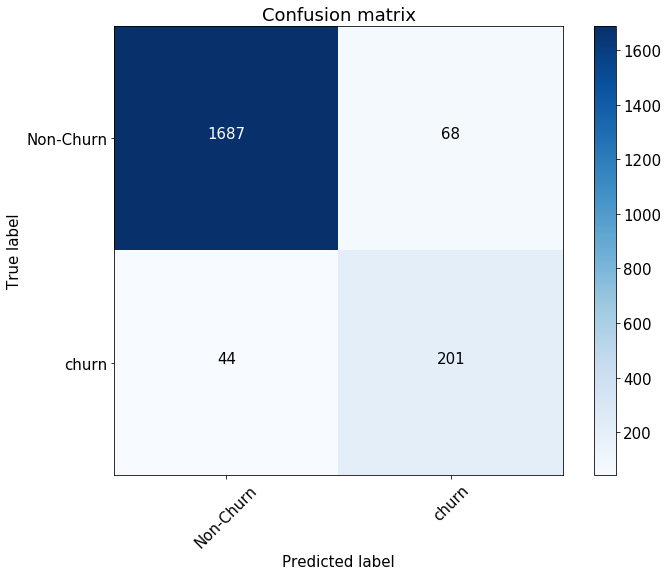

In [81]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [82]:
roc_auc_score(y_test, preds)

0.9755916041630327

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Mean : F-Score=0.721, Precision=0.659, Recall=0.796, Roc_Auc = 0.959

Median : F-Score=0.754, Precision=0.723, Recall=0.788, Roc_Auc = 0.968

Max : F-Score=0.784, Precision=0.748, Recall=0.824, Roc_Auc = 0.975

In [122]:
results = pd.DataFrame([['Mean', 0.721, 0.659, 0.796, 0.959], ['Median', 0.754, 0.723, 0.788, 0.968], ['Max', 0.784, 0.748, 0.824, 0.975]], columns=['Method', 'F-Score', 'Precision', 'Recall', 'Roc-Auc'])

In [123]:
results

,Method,F-Score,Precision,Recall,Roc-Auc
0,Mean,0.721,0.659,0.796,0.959
1,Median,0.754,0.723,0.788,0.968
2,Max,0.784,0.748,0.824,0.975


В целом, все методы работают неплохо, но метод max дает наилучшие результаты. С его помощью удалось выявить наибольшее количество кандидатов на отток с наибольшей точностью. Вероятно, что при применении метода max мы более точно определяем интерес пользователя к той или иной теме. Если пользователь, например, прочитал половину статей на одну тему, а половину статей на другую тему, то методы median и mean будут менее эффективны при определении интересов пользователя. Можно предположить,  что есть зависимость между интересами пользователя и оттоком. Возможно, какие-то темы новостного портала предлагают менее качественный контент, и заинтересованные в этих темах пользователи уходят искать информацию на другие сайты.